In [59]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
import random
import math

# Combining Analytical Modeling and Machine Learning
Our objective is to combine a machine learning model atop an analytical model to show that a combination between the two approaches can achieve a higher score than the analytical model without the machine learning approach. Additionally we're interested in displaying that this can automatically deal with problems such as concept drift if training examples are captured in a feedback loop.

All conccepts borrowed from:

Enhancing Performance Prediction Robustness by Combining Analytical Modeling and Machine Learning
Diego Didona, et al.
https://www.researchgate.net/publication/269039025_Enhancing_Performance_Prediction_Robustness_by_Combining_Analytical_Modeling_and_Machine_Learning


## Data
We have been tasked with predicting the number of requests `y` we will be able to serve with a specific cloud deployment of size `x`. There are some catches with our data though! Our cloud deployment _requires 250 servers_ before it is fully operational and capable of serving client requests -- consequently we cannot serve any requests until we've scaled to that size.

Furthermore a service that we depend on starts to taper off eventually because it becomes overloaded and we cannot serve any additional requests by scaling further.

You've been tasked with predicting how many requests we can serve given a specific deployment size.

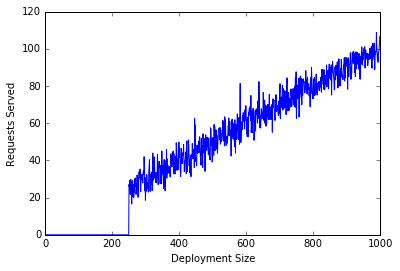

In [62]:
# Data
data = np.random.normal(0.0, 5.0, 1000) + np.linspace(0, 100, 1000)
data[0:250] = 0.0
xs = np.arange(0, 1000)
plt.plot(data)
plt.xlabel("Deployment Size")
plt.ylabel("Requests Served")
plt.show()

## Analytical Model
The first step you take is talking to a devops engineer. She suggests that they've observed that we can serve approximately 1 client per 10 servers (it is a distributed application running heavy workloads!). We take this domain knowledge and encode it into an analytical model function named model.

Let's plot how well our model fits the data, as well as calculate the root mean squared error (RMSE) so that we can objectively compare model approaches.

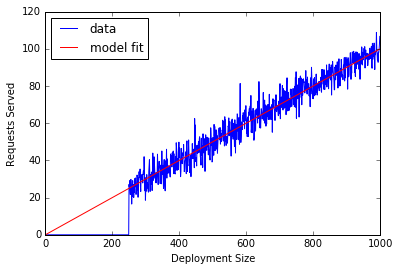

Root Mean Squared Error:  8.456976801664531


In [63]:
# Our Analytical Model
# Relatively simple but assumes the linear model of y = 0.1x
def model(x):
    return 0.1 * x
vmodel = np.vectorize(model)

# Calcualtes the error at any given data point x.
def error(data, x, y):
    return data[x] - y

# Root mean squared error given all data and a set of predictions.
def rmse(data, ys):
    return math.sqrt(((data - ys) ** 2).mean())

plt.plot(data, label="data")
plt.plot(vmodel(xs), color="red", label="model fit")
plt.legend(loc="upper left")
plt.xlabel("Deployment Size")
plt.ylabel("Requests Served")
plt.show()

print("Root Mean Squared Error: ", rmse(data, vmodel(xs)))

## Concept Drift
We did alright, in fact looking at the graph we're pretty accurate in most of the space. The model isn't perfect though because we don't capture the lower range in which we don't have a full deployment.

Furthermore a service that we depend on, a database managed by another department with their own cloud deployment, updated to the latest version which has different performance characteristsics. They can't seem to scale it past approximately 80 concurrent connections. We've experienced **concept drift** because our data has changed which has altered the performance of our model.

Let's take a look at what this looks like now.

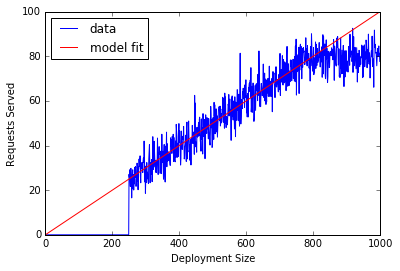

Root Mean Squared Error:  10.043811196954573


In [68]:
data[800:] = data[775:800].mean() + np.random.normal(0.0, 5.0, 200)
plt.plot(data, label="data")
plt.plot(vmodel(xs), color="red", label="model fit")
plt.legend(loc="upper left")
plt.xlabel("Deployment Size")
plt.ylabel("Requests Served")
plt.show()

print("Root Mean Squared Error: ", rmse(data, vmodel(xs)))

## Machine Learning
It appears as though our RMSE scoe got worse (higher error is worse!). You then recall these two nut jobs at Strata (Ram and Cody) who suggested that you could combine machine learning and analytical modeling in a feedback loop to improve the performance of an analytical model.

We implement a simple feature space for the algorithm which is just the bit array representing the `x` values, the size of the cloud deployment.

We use an error function that tells us how many concurrent clients we were actually able to support vs how many clients our model predicted we could perform.

The trick here is that we're training a Support Vector Machine (SVM) to predict the error of our model, imagine that about 1/3 of our training data ends up being in the 0-250 range, and about 1/3 in the 800+ range because we've tuned our system to gather more training examples when we're having issues serving all of the load.

In [71]:
def features(x):
    return np.array([int(a) for a in bin(x)[2:].zfill(16)], dtype=np.int32)

training_x = []
training_y = []
for i in range(500):
    random_x = random.randint(0,250)
    training_x.append(features(random_x))
    training_y.append(error(data, random_x, model(random_x)))

for i in range(500):
    random_x = random.randint(0,999)
    training_x.append(features(random_x))
    training_y.append(error(data, random_x, model(random_x)))
    
for i in range(500):
    random_x = random.randint(800,999)
    training_x.append(features(random_x))
    training_y.append(error(data, random_x, model(random_x)))

svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_rbf.fit(training_x, training_y)

print(svr_rbf.predict([features(900)]))
print(error(data, 900, model(900)))

[-14.11286176]
-12.7329363619


## Combined Model
Alright great, so we have a Support Vector Machine that can predict how large of a mistake our analytical model might make at any given point in data. How can we take advantage of this?

What if we create a combined model that uses the prediction from the original model, and adds the predicted error to our prediction?

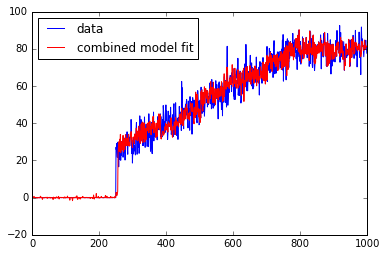

Root Mean Squared Error:  5.0452164463411755


In [75]:
def combined_model(x):
    am_prediction = model(x)
    err_prediction = svr_rbf.predict([features(x)])[0]
    return am_prediction + err_prediction
vcombined = np.vectorize(combined_model)

plt.plot(data, label="data")
plt.plot(vcombined(xs), color="red", label="combined model fit")
plt.legend(loc="upper left")
plt.show()

print("Root Mean Squared Error: ", rmse(data, vcombined(xs)))

## Conclusion
What have we achieved here? We have shown that if we're given or have created an imperfect analytical model we can improve it's performance by pairing it with a machine learning algorithm. Furthermore this machine learning algorithm can be regularly retrained using new training examples... if our error increases sharply we can trigger a re-training event in an attempt to reduce error. The benefits of this are evident when we consider concept drift as in above, if a feedback loop is automatically generating these training examples the system will self correct without human intervention.

### Homework 1
Modify the code in this notebook such that you have trained an svm before the concept drift to correct the mistakes up to 250. Then after the concept drift re-train the SVM with samples from before and new samples to show how we can adapt continually to drift and changes.

### Homework 2
Think about the problems you're facing in your day job with production analytical modelling systems. Can you think of a place where users would be able to either explicitly or implicitly provide feedback that you could encode as a training example?